## Challenge of deep learning 

### Sensor (by Sensor Logger APP)

- 11 Sensors data are collected: **'TotalAcceleration'** (only in android), 'Barometer', 'Location', 'Orientation', '**Magnetometer**', 'GyroscopeUncalibrated', 'MagnetometerUncalibrated', '**Accelerometer**', 'AccelerometerUncalibrated', '**Gyroscope**', '**Gravity**'

- We should **use only the calibrated data.** Sensor Logger gives you the option to log raw, uncalibrated data from the accelerometer, gyroscope and magnetometer. Calibrated data is always logged. The raw stream is useful for performing lower-level post-processing or custom sensor fusion. If in doubt, **always use the calibrated version** unless you have a good reason not to. https://github.com/tszheichoi/awesome-sensor-logger#when-to-use-uncalibrated-data

**Info from App**
- Device Acceleration (Accelerometer; Raw & Calibrated)
- **Gravity Vector** (Accelerometer)
- Device **Rotation** Rate (**Gyroscope**; Raw & Calibrated)
- Device Orientation (Gyroscope)
- Magnetic Heading (**Magnetometer**; Raw & Calibrated)
- Barometric Altitude (Barometer)
- GPS Coordinate, Altitude, Speed & Heading

**Selection:**
- **acceleration/Beschleunigungs:** 
    - **Accelerometer**: measures **linear acceleration** (?) and the vibration. Units are **meters per second squared (𝑚/𝑠2)** or **G- forces (𝑔)**.
    - **Gravity**: 
- **rotation sensor:** 
    - **Gyroscope**: uses Earth's gravity to help determine orientation. Gyro sensors are devices that sense **angular velocity** which is the change in rotational angle per unit of time. Angular velocity is generally expressed in deg/s (**degrees per second**).
- **magnetometer:** 
    - **Magnetometer**: is generally **assembled with an accelerometer and a gyroscope** into an **inertial unit**. It measures the change of a magnetic field at a particular location. The measurement units are Tesla (𝑇 ), and the sampling rate is from tens to hundreds of Hz.

### 10 User

### Activity 
- laufen
- joggen
- treppelaufen
- velofahre
- stehen
- sitzen

### Data size
- 10 records per user per activity
- d.h. 100 records for each activity, 60 records from each user 

### Deep learning models for human activity recognition time series data classification
- Convolutional Neural Networks (CNNs) - CNNs have been successful in capturing the temporal and spatial patterns in the data. In particular, 1D-CNNs are used for time series data, where each time step is treated as a separate channel.

- Recurrent Neural Networks (RNNs) - RNNs are well suited for sequential data, as they can capture the dependencies between each time step. Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) are popular variants of RNNs that have shown good results for time series classification.

- Hybrid CNN-RNN models - Hybrid models that combine CNNs and RNNs have also been used for human activity recognition. These models use CNNs to extract local features from the input data and RNNs to capture the temporal dependencies.

- Transformers - Transformers are a relatively new type of deep learning model that have shown promising results for sequence data. They are particularly well-suited for long sequences, as they can attend to relevant information and ignore irrelevant information.

- The choice of model depends on various factors such as the size of the dataset, the complexity of the problem, and the computational resources available. Experimenting with different models and hyperparameters is often required to find the best model for a given task.










In [4]:
import json
import glob
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import wandb
wandb.login()


True

## 1. load data
### 1.1 load tensor files

[(0, 'laufen'),
  (1, 'rennen'),
  (2, 'sitzen'),
  (3, 'stehen'),
  (4, 'treppelaufen'),
  (5, 'velo')]

In [5]:

# Load the data
# all iphone users
train_X = torch.load('../Daten/train-test/tensor/X_train_minmax_iphone.pt').float()
test_X = torch.load('../Daten/train-test/tensor/X_test_minmax_iphone.pt').float()
train_y = torch.load('../Daten/train-test/tensor/y_train_minmax_iphone.pt').long()
test_y = torch.load('../Daten/train-test/tensor/y_test_minmax_iphone.pt').long()

# small set from weiping
#train_X = torch.load('train-test_of_18_records/X_train.pt')
#test_X = torch.load('train-test_of_18_records/X_test.pt')
#train_y = torch.load('train-test_of_18_records/y_train.pt')
#test_y = torch.load('train-test_of_18_records/y_test.pt')

train_X.size(), test_X.size(), train_y.size(), test_y.size()


(torch.Size([252, 800, 12]),
 torch.Size([108, 800, 12]),
 torch.Size([252]),
 torch.Size([108]))

### configuration understanding of 1D CNN and simple LSTM

**nn.Conv1d(12, 32, 3, padding=1)**: 12 input channels, 32 output channels, and a kernel size of 3

- input size of the first layer is determined by the shape of the input tensor. input tensor has 12 channels, this means it has a shape of (batch_size, 12, length), where batch_size is the number of samples in the batch, and length is the length of the input sequence. The 12 channels could correspond to different features or sensors that are being used as inputs to the model.
    
- For example, a time series classification problem with 12 different sensors recording signals at different frequencies, then the input tensor could have 12 channels, one for each sensor.

In [6]:
config = {
    "epochs": 100,
    "learning_rate": 0.001,
    "batch_size": 32,
    "num_lstm_layers": 1,
    "hidden_size": 64,
    "dropout": 0.5,
    "optimizer": "Adam",
    "loss_function": "CrossEntropyLoss",
    
    # Add any other hyperparameters
}
wandb.init(project="cdl_fs2023", config=config)

In [14]:

# Define the 1-D CNN architecture
class Simple1DCNN(nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        # input: 12 features, output 32 features, kernel size 3
        self.conv1 = nn.Conv1d(12, 32, 3, padding=1)
        # activation function
        self.relu = nn.ReLU()
        # max pooling layer
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * 400, 64)
        self.fc2 = nn.Linear(64, 6)  # Change the output size to match the number of classes

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define a simple LSTM architecture
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=800, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 6)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Get the output from the last time step
        last_time_step = lstm_out[:, -1, :]
        # Fully connected layer
        out = self.fc(last_time_step)
        return out

batch_size = 20
# Prepare the data for training and testing
train_dataset = TensorDataset(train_X.transpose(1, 2), train_y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_X.transpose(1, 2), test_y)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
def train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=100):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_losses.append(epoch_loss / len(train_dataloader))
        train_accuracies.append(correct_train / total_train * 100)

        # Evaluate the model
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predicted_test = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()

        test_accuracies.append(correct_test / total_test * 100)
        model.train()

        # Log the metrics to WandB
        wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Test Accuracy": test_accuracies[-1]})
        

    return train_losses, train_accuracies, test_accuracies



def plot_results(train_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


### 1D CNN

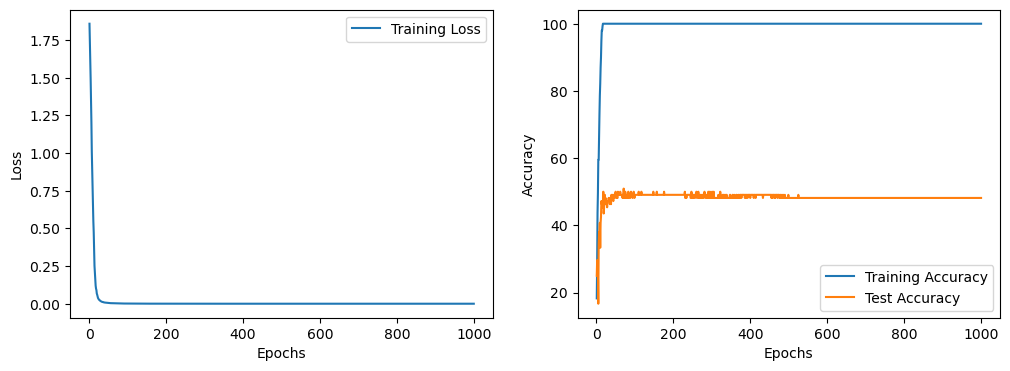

In [12]:
# Adam 1D CNN
# Create the model, loss function, and optimizer
model = Simple1DCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the 1D CNN and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)


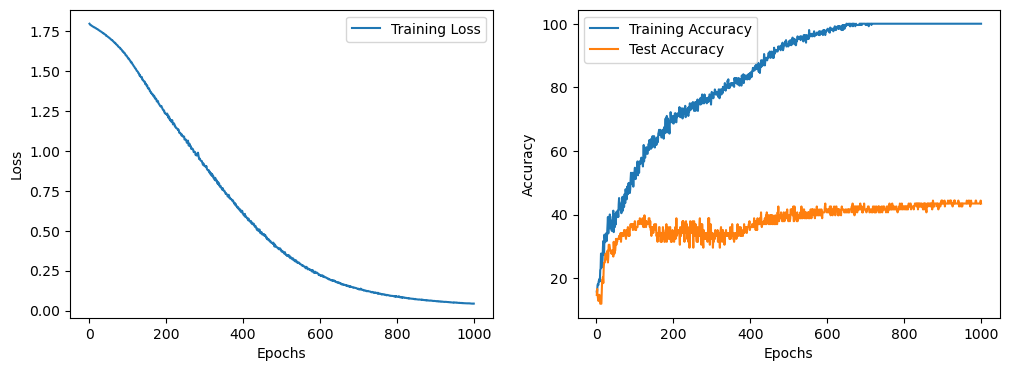

In [13]:
# SGD 1D CNN
# Create the model, loss function, and optimizer
model = Simple1DCNN()# or SimpleLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the 1D CNN and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)

### LSTM

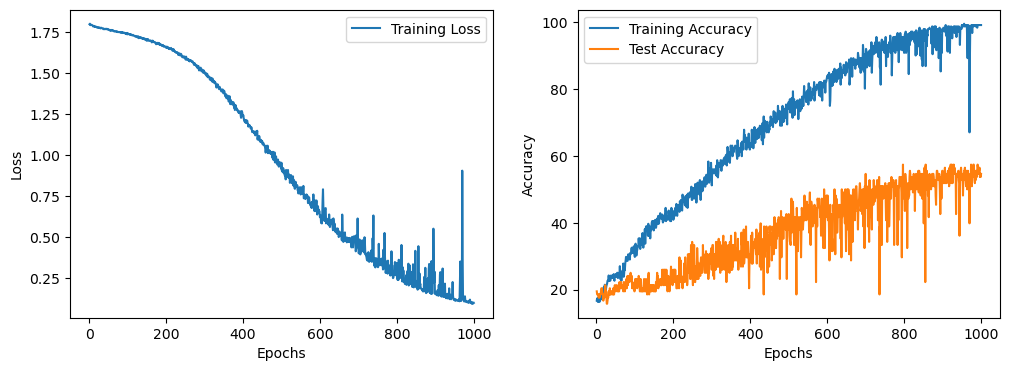

In [19]:
# SGD LSTM 1000 epochs, 1 layer 

# Create the model, loss function, and optimizer
model = SimpleLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the 1D LSTM and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)

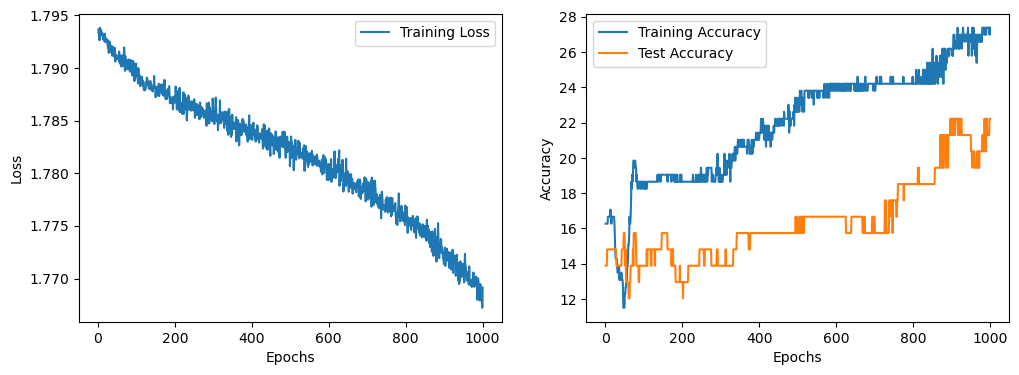

In [15]:
# SGD LSTM 1000 epochs, 2 layers 

# Create the model, loss function, and optimizer
model = SimpleLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the 1D LSTM and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)